In [2]:
import kagglehub

# Try downloading without authentication
try:
    path = kagglehub.dataset_download("ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy")
    print(f"Success! Dataset at: {path}")
except Exception as e:
    print(f"Authentication needed: {e}")

Success! Dataset at: /kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy


In [3]:
print(path)

/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy


In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
!nvidia-smi

Sun Nov  9 05:45:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data_dir = os.path.join(path, 'augmented_resized_V2')
print(data_dir)

/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2


In [12]:
path = "/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy"
data_dir = os.path.join(path, "augmented_resized_V2")
print(data_dir)

/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2


In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224 , 0.225])
train_transforms = transforms.Compose([transforms.ToTensor(),
                                    normalize
                                    ])
val_transforms = transforms.Compose([transforms.ToTensor(), normalize])

In [8]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=train_transforms)

In [13]:
print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 115241
Number of images in validation dataset: 14227
Number of images in test dataset: 14201


In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
from torchvision import models
import torch.nn as nn

model = models.resnet50(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last block and classifier
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Replace final layer for 5-class classification
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s] 


In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.utils.class_weight import compute_class_weight

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_dir = "/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2/train"
val_dir = "/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2/val"

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
class_counts = [6896, 1862, 2999, 978, 1466]
classes = torch.arange(len(class_counts))
class_weights = compute_class_weight(class_weight='balanced', classes=classes.numpy(), y=np.repeat(classes.numpy(), class_counts))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 3
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    print(f"📉 Train Loss: {epoch_loss:.4f} | 📈 Train Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_acc = val_running_corrects.double() / len(val_dataset)
    print(f"🧪 Validation Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_model_v2.pth")
        print("💾 Best model saved.")

In [12]:
model.load_state_dict(torch.load("/kaggle/working/best_model_v2.pth"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = correct / total
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f}")

✅ Final Validation Accuracy: 0.7217


              precision    recall  f1-score   support

           0     0.8118    0.9485    0.8749      6895
           1     0.7084    0.4277    0.5334      1840
           2     0.6469    0.4544    0.5338      3024
           3     0.4233    0.6760    0.5206      1000
           4     0.6654    0.6069    0.6348      1468

    accuracy                         0.7217     14227
   macro avg     0.6512    0.6227    0.6195     14227
weighted avg     0.7210    0.7217    0.7085     14227



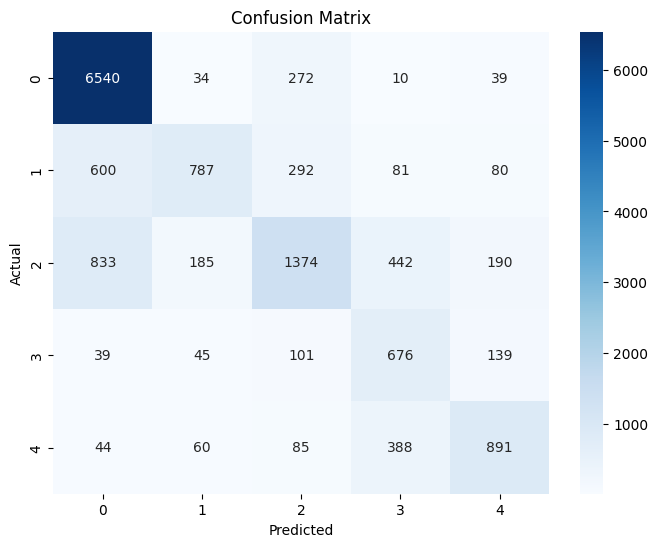

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [17]:
# Use same class_weights from earlier
criterion = FocalLoss(alpha=class_weights, gamma=2)

In [ ]:
num_epochs = 5
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    print(f"📉 Train Loss: {epoch_loss:.4f} | 📈 Train Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_acc = val_running_corrects.double() / len(val_dataset)
    print(f"🧪 Validation Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_model_focal.pth")
        print("💾 Best model saved.")

In [19]:
model.load_state_dict(torch.load("/kaggle/working/best_model_focal.pth"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = correct / total
print(f"✅ Final Validation Accuracy (Focal Loss): {val_accuracy:.4f}")

✅ Final Validation Accuracy (Focal Loss): 0.6136


In [21]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8735    0.7192    0.7889      6895
           1     0.3584    0.6500    0.4620      1840
           2     0.5000    0.3753    0.4288      3024
           3     0.3698    0.7870    0.5032      1000
           4     0.8000    0.4441    0.5712      1468

    accuracy                         0.6136     14227
   macro avg     0.5804    0.5951    0.5508     14227
weighted avg     0.6845    0.6136    0.6275     14227



In [22]:
criterion = FocalLoss(alpha=class_weights, gamma=2)

In [23]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
num_epochs = 5
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    print(f"📉 Train Loss: {epoch_loss:.4f} | 📈 Train Acc: {epoch_acc:.4f}")


🔁 Epoch 1/5
📉 Train Loss: 0.5586 | 📈 Train Acc: 0.5184


In [27]:
model.eval()
val_running_corrects = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_running_corrects += torch.sum(preds == labels.data)

val_acc = val_running_corrects.double() / len(val_dataset)
print(f"🧪 Final Validation Accuracy: {val_acc:.4f}")

if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(model.state_dict(), "/kaggle/working/best_model_focal_scheduler.pth")
    print("💾 Best model saved.")

🧪 Final Validation Accuracy: 0.5889
💾 Best model saved.



📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8856    0.6492    0.7492      6895
           1     0.3417    0.6576    0.4497      1840
           2     0.4723    0.3912    0.4279      3024
           3     0.3648    0.7950    0.5002      1000
           4     0.7532    0.4864    0.5911      1468

    accuracy                         0.5889     14227
   macro avg     0.5635    0.5959    0.5436     14227
weighted avg     0.6771    0.5889    0.6084     14227



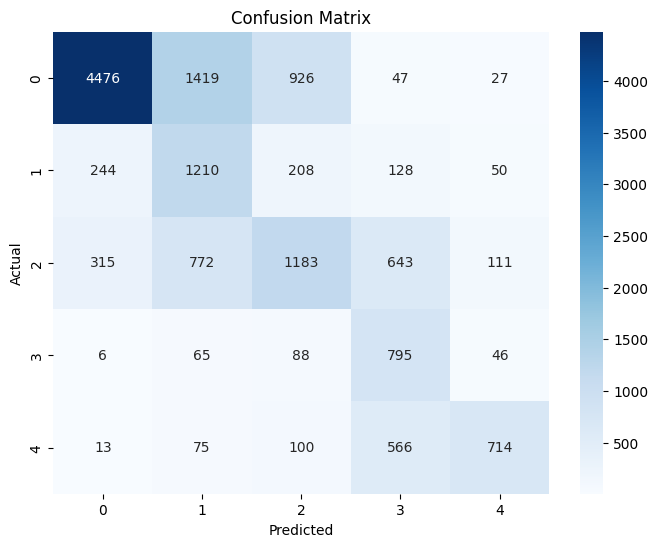

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("/kaggle/working/best_model_focal_scheduler.pth"))
model.to(device)
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
tta_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [37]:
def tta_predict(model, image, n=5):
    model.eval()
    outputs = []

    with torch.no_grad():
        for _ in range(n):
            aug_image = tta_transforms(image).unsqueeze(0).to(device)
            output = model(aug_image)
            outputs.append(output)

    avg_output = torch.mean(torch.stack(outputs), dim=0)
    _, predicted = torch.max(avg_output, 1)
    return predicted.item()

In [38]:
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()

def tta_predict(model, image_tensor, n=5):
    model.eval()
    outputs = []

    with torch.no_grad():
        for _ in range(n):
            pil_image = to_pil(image_tensor.cpu())  # Convert tensor to PIL
            aug_image = tta_transforms(pil_image).unsqueeze(0).to(device)
            output = model(aug_image)
            outputs.append(output)

    avg_output = torch.mean(torch.stack(outputs), dim=0)
    _, predicted = torch.max(avg_output, 1)
    return predicted.item()


📊 TTA Classification Report:
              precision    recall  f1-score   support

           0     0.7286    0.0074    0.0146      6895
           1     0.1316    0.7658    0.2246      1840
           2     0.2500    0.0003    0.0007      3024
           3     0.1578    0.1310    0.1432      1000
           4     0.2681    0.4782    0.3436      1468

    accuracy                         0.1612     14227
   macro avg     0.3072    0.2765    0.1453     14227
weighted avg     0.4620    0.1612    0.0818     14227



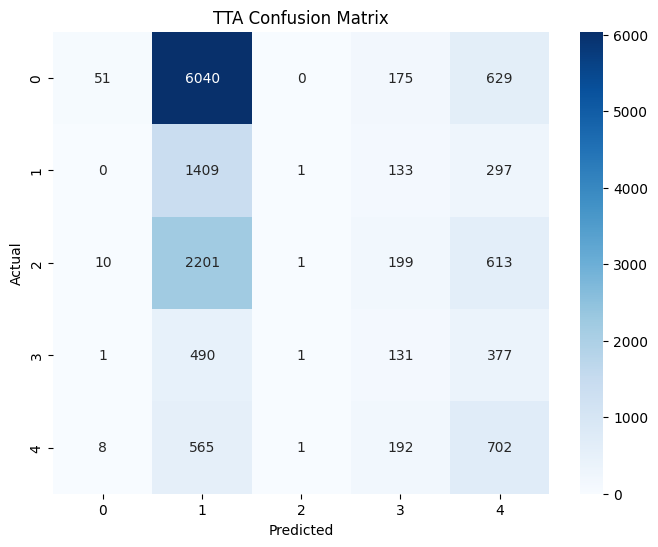

In [39]:
all_preds = []
all_labels = []

model.load_state_dict(torch.load("/kaggle/working/best_model_focal_scheduler.pth"))
model.to(device)
model.eval()

for images, labels in val_loader:
    for i in range(images.size(0)):
        image = images[i]
        label = labels[i].item()

        pred = tta_predict(model, image, n=5)
        all_preds.append(pred)
        all_labels.append(label)

# Evaluation
print("\n📊 TTA Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("TTA Confusion Matrix")
plt.show()


In [40]:
model.load_state_dict(torch.load("/kaggle/working/best_model_v2.pth"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = correct / total
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f}")

✅ Final Validation Accuracy: 0.7217


In [42]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8118    0.9485    0.8749      6895
           1     0.7084    0.4277    0.5334      1840
           2     0.6469    0.4544    0.5338      3024
           3     0.4233    0.6760    0.5206      1000
           4     0.6654    0.6069    0.6348      1468

    accuracy                         0.7217     14227
   macro avg     0.6512    0.6227    0.6195     14227
weighted avg     0.7210    0.7217    0.7085     14227



In [51]:
import pandas as pd

# Load the synthetic clinical dataset
synthetic_df = pd.read_csv("/kaggle/input/synthetic-clinical-data/synthetic_dr_clinical_data.csv")

# Preview the first few rows
synthetic_df.head()

,image_id,dr_grade,hba1c,bp,duration
0,img_0,1,6.671773,136.442194,9.640440
1,img_1,1,6.905166,135.907723,10.182376
2,img_2,0,7.319631,136.741074,7.973583
3,img_3,0,6.772070,143.339338,9.183441
4,img_4,1,7.724807,144.754430,9.645265


In [52]:
import numpy as np

# Simulate 2048-dim image feature vectors for each image_id
image_features = {
    img_id: np.random.rand(2048).astype(np.float32)
    for img_id in synthetic_df["image_id"]
}

In [54]:
fusion_data = []

for _, row in synthetic_df.iterrows():
    img_id = row["image_id"]
    dr_grade = row["dr_grade"]
    clinical_vector = [row["hba1c"], row["bp"], row["duration"]]
    image_vector = image_features[img_id]

    fusion_data.append((image_vector, clinical_vector, dr_grade))

In [55]:
import torch
from torch.utils.data import Dataset

class FusionDataset(Dataset):
    def __init__(self, fusion_data):
        self.data = fusion_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_vector, clinical_vector, label = self.data[idx]
        image_tensor = torch.tensor(image_vector, dtype=torch.float32)
        clinical_tensor = torch.tensor(clinical_vector, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, clinical_tensor, label_tensor

In [56]:
from torch.utils.data import DataLoader

# Create dataset and loader
dataset = FusionDataset(fusion_data)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [57]:
import torch.nn as nn

class FusionModel(nn.Module):
    def __init__(self, image_feature_size=2048, clinical_feature_size=3, num_classes=5):
        super(FusionModel, self).__init__()

        self.image_branch = nn.Sequential(
            nn.Linear(image_feature_size, 256),
            nn.ReLU()
        )

        self.clinical_branch = nn.Sequential(
            nn.Linear(clinical_feature_size, 32),
            nn.ReLU()
        )

        self.fusion = nn.Sequential(
            nn.Linear(256 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image_features, clinical_features):
        img_out = self.image_branch(image_features)
        clin_out = self.clinical_branch(clinical_features)
        combined = torch.cat((img_out, clin_out), dim=1)
        return self.fusion(combined)

In [58]:
model = FusionModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [59]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image_tensor, clinical_tensor, label_tensor in train_loader:
        image_tensor = image_tensor.to(device)
        clinical_tensor = clinical_tensor.to(device)
        label_tensor = label_tensor.to(device)

        optimizer.zero_grad()
        outputs = model(image_tensor, clinical_tensor)
        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/10] - Loss: 3.4830
Epoch [2/10] - Loss: 1.9566
Epoch [3/10] - Loss: 1.5077
Epoch [4/10] - Loss: 1.8620
Epoch [5/10] - Loss: 1.4655
Epoch [6/10] - Loss: 1.7444
Epoch [7/10] - Loss: 1.6164
Epoch [8/10] - Loss: 1.4882
Epoch [9/10] - Loss: 1.4637
Epoch [10/10] - Loss: 1.3781


In [60]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for image_tensor, clinical_tensor, label_tensor in train_loader:
        image_tensor = image_tensor.to(device)
        clinical_tensor = clinical_tensor.to(device)
        label_tensor = label_tensor.to(device)

        outputs = model(image_tensor, clinical_tensor)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_tensor.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.3247    1.0000    0.4902        25
           1     0.0000    0.0000    0.0000        22
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        18
           4     0.8261    0.9048    0.8636        21

    accuracy                         0.4400       100
   macro avg     0.2302    0.3810    0.2708       100
weighted avg     0.2546    0.4400    0.3039       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
class_weights = torch.tensor([1.0, 2.0, 2.0, 2.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [62]:
import pandas as pd

df = pd.read_csv("/kaggle/input/synthetic-clinical-data/synthetic_dr_clinical_data.csv")

In [63]:
df.head()

,image_id,dr_grade,hba1c,bp,duration
0,img_0,1,6.671773,136.442194,9.640440
1,img_1,1,6.905166,135.907723,10.182376
2,img_2,0,7.319631,136.741074,7.973583
3,img_3,0,6.772070,143.339338,9.183441
4,img_4,1,7.724807,144.754430,9.645265


In [64]:
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Add Gaussian noise
df["hba1c"] += np.random.normal(0, 0.3, size=len(df))      # mean=0, std=0.3
df["bp"] += np.random.normal(0, 5, size=len(df))           # mean=0, std=5
df["duration"] += np.random.normal(0, 1.5, size=len(df))   # mean=0, std=1.5

# Optional: clip to realistic ranges
df["hba1c"] = df["hba1c"].clip(4.5, 15)
df["bp"] = df["bp"].clip(90, 200)
df["duration"] = df["duration"].clip(0, 40)

In [65]:
df.to_csv("/kaggle/working/synthetic_dr_clinical_data_noisy.csv", index=False)

In [66]:
import pandas as pd

# Load the noisy clinical dataset
df_noisy = pd.read_csv("/kaggle/working/synthetic_dr_clinical_data_noisy.csv")

In [67]:
fusion_data_noisy = []

for _, row in df_noisy.iterrows():
    img_id = row["image_id"]
    dr_grade = row["dr_grade"]
    clinical_vector = [row["hba1c"], row["bp"], row["duration"]]
    image_vector = image_features[img_id]  # same simulated image features

    fusion_data_noisy.append((image_vector, clinical_vector, dr_grade))

In [68]:
from torch.utils.data import DataLoader

dataset_noisy = FusionDataset(fusion_data_noisy)
train_loader_noisy = DataLoader(dataset_noisy, batch_size=32, shuffle=True)

In [69]:
model = FusionModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image_tensor, clinical_tensor, label_tensor in train_loader_noisy:
        image_tensor = image_tensor.to(device)
        clinical_tensor = clinical_tensor.to(device)
        label_tensor = label_tensor.to(device)

        optimizer.zero_grad()
        outputs = model(image_tensor, clinical_tensor)
        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_noisy)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/10] - Loss: 2.9590
Epoch [2/10] - Loss: 2.3345
Epoch [3/10] - Loss: 1.7884
Epoch [4/10] - Loss: 1.6648
Epoch [5/10] - Loss: 1.5485
Epoch [6/10] - Loss: 1.4909
Epoch [7/10] - Loss: 1.4480
Epoch [8/10] - Loss: 1.5256
Epoch [9/10] - Loss: 1.3855
Epoch [10/10] - Loss: 1.3182


In [70]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for image_tensor, clinical_tensor, label_tensor in train_loader_noisy:
        image_tensor = image_tensor.to(device)
        clinical_tensor = clinical_tensor.to(device)
        label_tensor = label_tensor.to(device)

        outputs = model(image_tensor, clinical_tensor)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_tensor.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.4237    1.0000    0.5952        25
           1     0.0000    0.0000    0.0000        22
           2     0.0000    0.0000    0.0000        14
           3     1.0000    0.2222    0.3636        18
           4     0.5405    0.9524    0.6897        21

    accuracy                         0.4900       100
   macro avg     0.3929    0.4349    0.3297       100
weighted avg     0.3994    0.4900    0.3591       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
samples_per_class = 20

balanced_df = (
    df.groupby("dr_grade", group_keys=False)
    .apply(lambda x: x.sample(n=samples_per_class, replace=True, random_state=42))
    .reset_index(drop=True)
)

/tmp/ipykernel_48/740331034.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, replace=True, random_state=42))


In [75]:
balanced_df.to_csv("/kaggle/working/synthetic_dr_clinical_data_balanced.csv", index=False)

In [76]:
import pandas as pd

# Load the balanced dataset
df_balanced = pd.read_csv("/kaggle/working/synthetic_dr_clinical_data_balanced.csv")

In [77]:
fusion_data_balanced = []

for _, row in df_balanced.iterrows():
    img_id = row["image_id"]
    dr_grade = row["dr_grade"]
    clinical_vector = [row["hba1c"], row["bp"], row["duration"]]
    image_vector = image_features[img_id]  # same simulated image features

    fusion_data_balanced.append((image_vector, clinical_vector, dr_grade))

In [78]:
from torch.utils.data import DataLoader

dataset_balanced = FusionDataset(fusion_data_balanced)
train_loader_balanced = DataLoader(dataset_balanced, batch_size=32, shuffle=True)

In [79]:
model = FusionModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image_tensor, clinical_tensor, label_tensor in train_loader_balanced:
        image_tensor = image_tensor.to(device)
        clinical_tensor = clinical_tensor.to(device)
        label_tensor = label_tensor.to(device)

        optimizer.zero_grad()
        outputs = model(image_tensor, clinical_tensor)
        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_balanced)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/10] - Loss: 2.1518
Epoch [2/10] - Loss: 1.9477
Epoch [3/10] - Loss: 1.7078
Epoch [4/10] - Loss: 1.5465
Epoch [5/10] - Loss: 1.5137
Epoch [6/10] - Loss: 1.3774
Epoch [7/10] - Loss: 1.2839
Epoch [8/10] - Loss: 1.2273
Epoch [9/10] - Loss: 1.1225
Epoch [10/10] - Loss: 1.0875


In [80]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for image_tensor, clinical_tensor, label_tensor in train_loader_balanced:
        image_tensor = image_tensor.to(device)
        clinical_tensor = clinical_tensor.to(device)
        label_tensor = label_tensor.to(device)

        outputs = model(image_tensor, clinical_tensor)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_tensor.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.4762    1.0000    0.6452        20
           1     0.7143    0.2500    0.3704        20
           2     1.0000    0.9000    0.9474        20
           3     0.9333    0.7000    0.8000        20
           4     1.0000    0.9000    0.9474        20

    accuracy                         0.7500       100
   macro avg     0.8248    0.7500    0.7421       100
weighted avg     0.8248    0.7500    0.7421       100



In [84]:
torch.save(model.state_dict(), "/kaggle/working/fusion_model_mvp.pth")

In [85]:
model = FusionModel()
model.load_state_dict(torch.load("/kaggle/working/fusion_model_mvp.pth"))
model.eval()

FusionModel(
  (image_branch): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
  )
  (clinical_branch): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
  )
  (fusion): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
  )
)